In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import yt
import os

dz = 0.5 nm
dielectric is always 4nm. 

check `domain_right_edge` for total thickness and ferroelectric thickness to determine dielectric boundary

In [2]:
data_dir = f"{os.environ['SCRATCH']}/bml/2D/pm5V"
output_dir = f"{os.environ['SCRATCH']}/bml/2D"

In [3]:
Q = list()           # shape = (n_t_fe,)
V_app = list()       # shape = (n_t_fe,)
V_fe_avg = list()    # shape = (n_t_fe,)
t_fe = list()        # shape = (n_t_fe,)

for path in glob.glob(f"{data_dir}/*/data.npz"):
    _tfe  = float(path.split('/')[-2][:-2])
    if _tfe > 12.0:
        continue
    npz = np.load(path)
    V_fe_avg.append(npz['V_fe_avg'])
    Q.append(npz['Q'])
    V_app.append(npz['V_app'])
    t_fe.append(_tfe)
    
Q = np.array(Q)
V_app = np.array(V_app)
V_fe_avg = np.array(V_fe_avg)
t_fe = np.array(t_fe)
order = np.argsort(t_fe)

t_fe = t_fe[order]
Q = Q[order]
V_app = V_app[order]
V_fe_avg = V_fe_avg[order]

print(t_fe)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12. ]


In [4]:
from scipy.stats import linregress


def calc_C(X, Y, step=5):
    order = np.argsort(X)
    mid = len(X) // 2
    order = order[mid-step:mid+step] 
    X, Y = X[order], Y[order]
    return linregress(X, Y), X, Y

C = np.zeros_like(t_fe)
for i in range(len(t_fe)):
    C[i] = calc_C(V_fe_avg[i], Q[i], step=3)[0].slope

dielectric thickness is always 4nm, and $\Delta z = 0.5$nm so we slice from index 8 forward

In [5]:
Pzs = list()             # shape = (n_t_fe, n_y, n_x, n_z)
from yt import set_log_level
from tqdm import tqdm
set_log_level('warning')

_tfes = list()
names = list()

for path in tqdm(glob.glob(f"{data_dir}/*nm")):
#for path in glob.glob(f"{data_dir}/[6,2,4].0nm"):
    _tfe  = float(path.split('/')[-1][:-2])
    if _tfe > 12.0:
        continue
    _tfes.append(_tfe)
    Pz_tmp = list()
    shape = None
    for i in sorted(glob.glob(f"{path}/plt*/")):
        ds = yt.load(i)
        name = i[i.find('plt')+3:-1]
        names.append(name)
        ad = ds.all_data()
        Pz = ad['boxlib', 'Pz'].to_ndarray().reshape(ds.domain_dimensions)
        if shape is not None:
            assert Pz.shape == shape
        else:
            shape = Pz.shape
        Pz_tmp.append(Pz[:, 0, 8:])
    Pzs.append(np.array(Pz_tmp))
order = np.argsort(_tfes)
Pzs = [Pzs[i] for i in order]
_tfes = [_tfes[i] for i in order]

100%|██████████| 29/29 [01:47<00:00,  3.71s/it]


In [6]:
Pvars = list()
for Pz in Pzs:
    tmp = list()
    for Pz_t in Pz:
        Pz_t = Pz_t.ravel()
        tmp.append(Pz_t.var())
    Pvars.append(np.array(tmp))
Pvars = np.array(Pvars)
Pvars = Pvars[:, 1:]

In [7]:
import matplotlib.colors as mpc
cmap = mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), 'Red'])


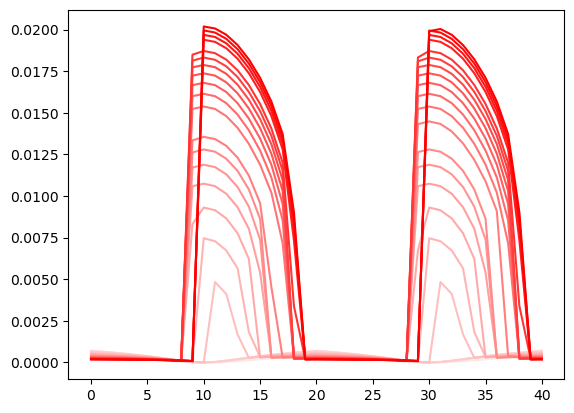

In [8]:
cmap = mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), 'Red'])

norm = t_fe.max()
for i in range(len(t_fe)):
    if i == 18:
        continue
    plt.plot(Pvars[i], c=cmap(t_fe[i]/norm));
plt.savefig(f'{output_dir}/Pvar_time.png')

In [9]:
def plot_arrows(x, y, t_fe=None):
    plt.scatter(x, y, c='k')
    for i in range(1, len(V_app[0])):
        plt.annotate("", (x[i-1], y[i-1]), (x[i], y[i]), arrowprops=dict(arrowstyle="->", color='gray'))
    if t_fe is not None:
        plt.title("$T_{fe} =" + f"{t_fe}$")

In [10]:
Q.shape

(23, 41)

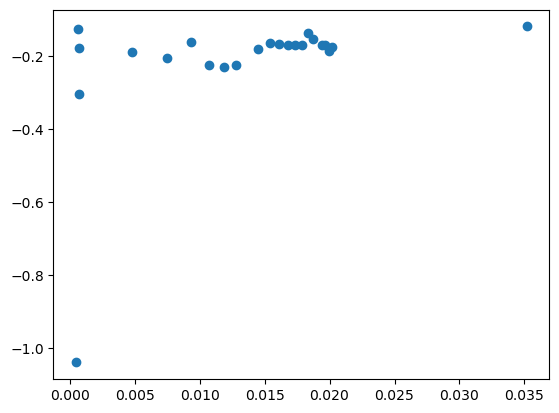

In [11]:
plt.scatter(Pvars.max(axis=1), C)

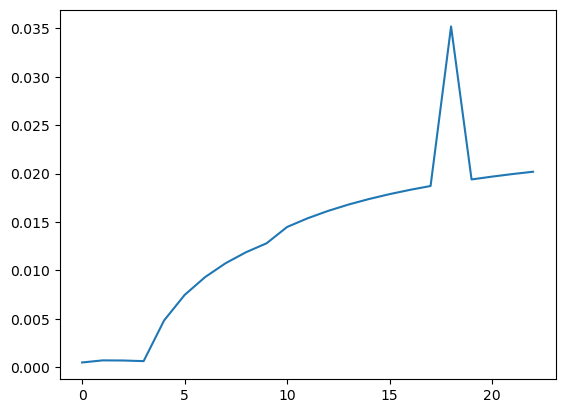

In [12]:
plt.plot(Pvars.max(axis=1))
plt.savefig(f'{output_dir}/Pvar_max_tfe.png')

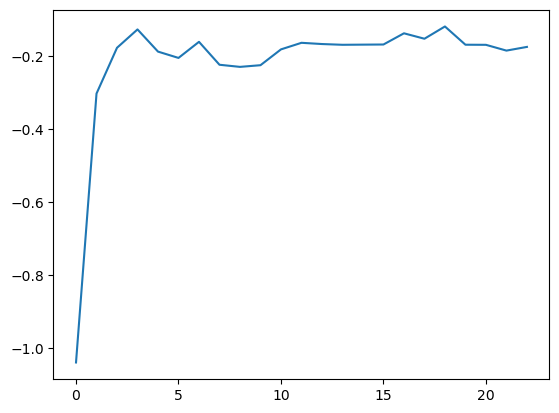

In [13]:
plt.plot(C)

In [14]:
def plot_Pz(Pz, ax=None, name=None, cbar=False):
    if ax is None:
        ax = plt.gca()
        
    im = ax.imshow(Pz.T, cmap='seismic', origin='lower')
    if cbar:
        plt.colorbar(im, ax=ax)

    if name is not None:
        ax.set_title(name)
    
    x, y = Pz.shape
    
    # add the x-ticks
    centers = np.arange(x+1, dtype=float)
    ticks = centers - 0.5
    labels = ['%.2g' % _ for _ in -1.6 + np.arange(centers.shape[0], dtype=float)*0.05]
    ax.set_xticks(ticks[0::8], labels=labels[0::8]);

    # add the y-ticks
    centers = np.arange(y+1, dtype=float)
    ticks = centers - 0.5
    labels = ['%.2g' % _ for _ in 4 + np.arange(centers.shape[0], dtype=float)*0.5]
    ax.set_yticks(ticks[0::4], labels=labels[0::4]);
    
    

10.5


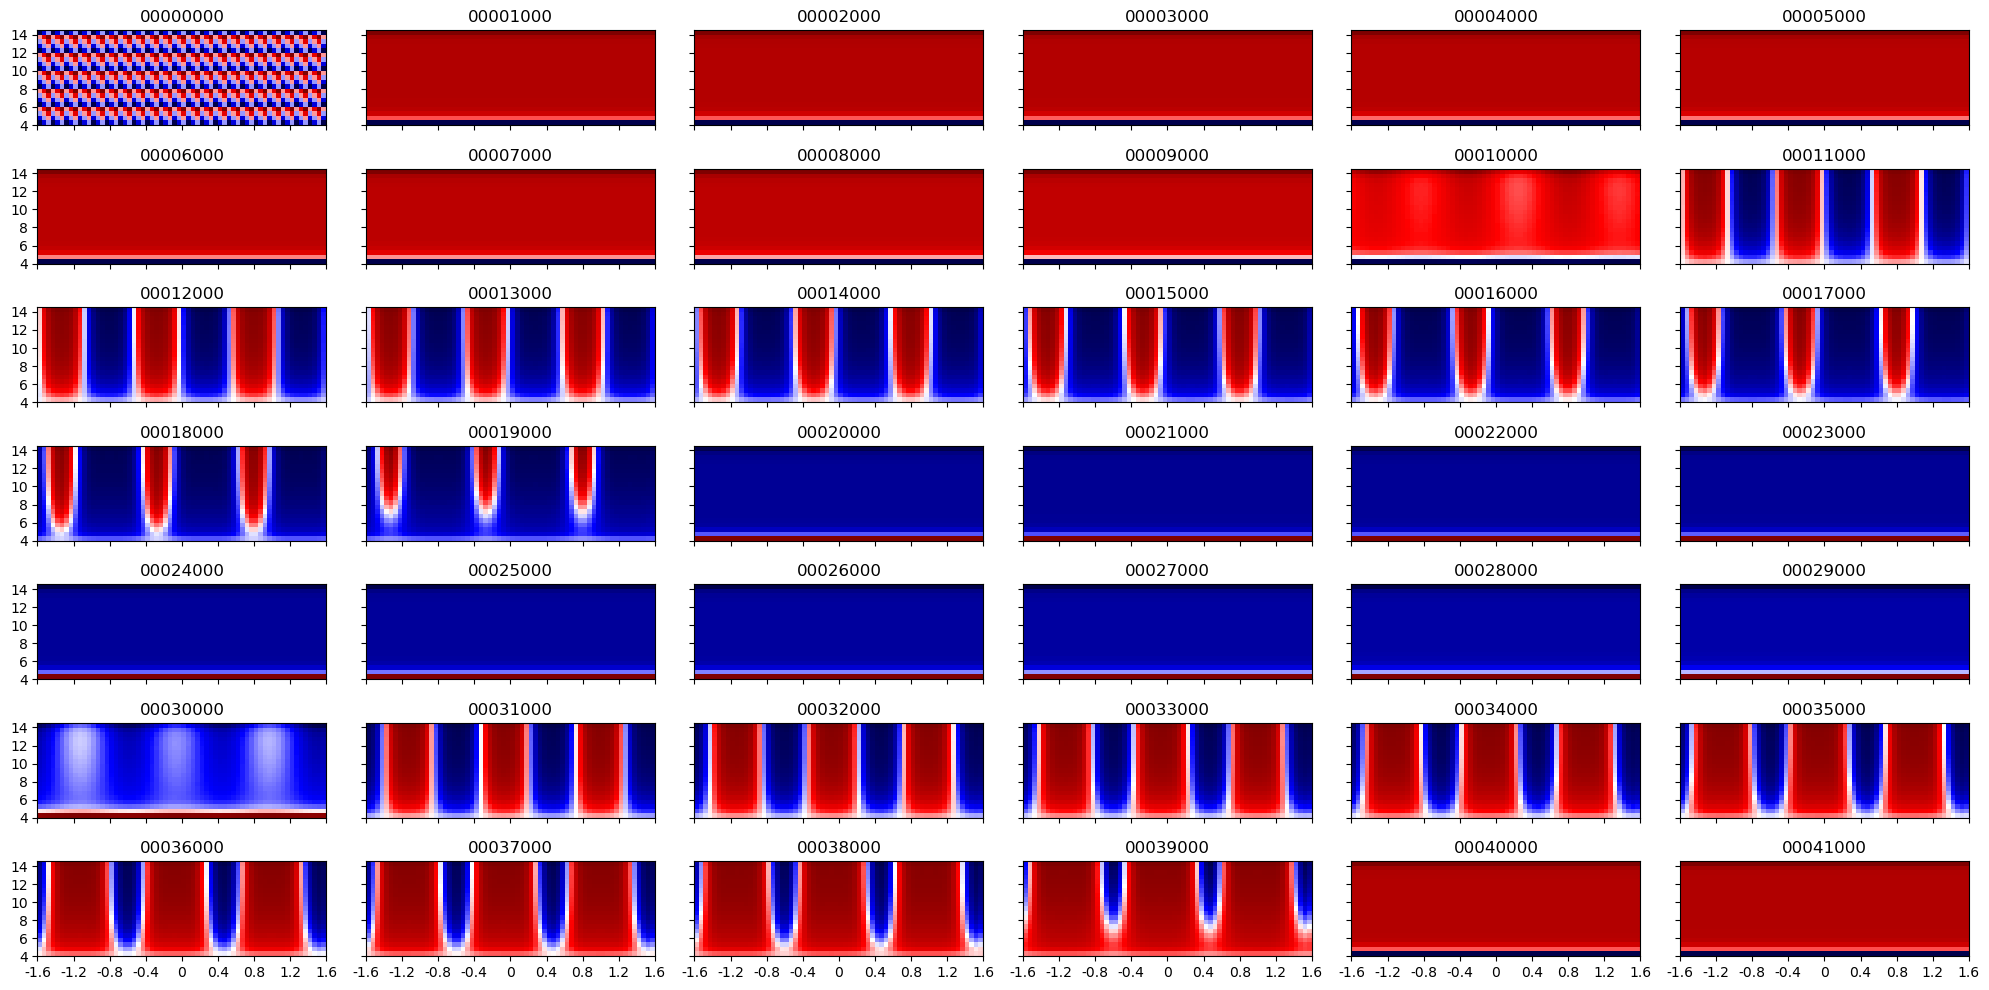

In [15]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10), sharex=True, sharey=True)
i = 19
print(t_fe[i])
for Pz, ax, name in zip(Pzs[i], axes.ravel(), names):
    plot_Pz(Pz, ax=ax, name=name)

plt.tight_layout()
plt.savefig(f'{output_dir}/viz.{t_fe[i]}nm.png')

In [ ]:
ds = yt.load("pm5V/5.0nm/plt00015000/")

In [ ]:
ad = ds.all_data()
Pz = ad['boxlib', 'Pz'].to_ndarray().reshape(ds.domain_dimensions)

In [ ]:
fe = Pz[:, 0, 8:]

In [ ]:
data_dir = f"{os.environ['SCRATCH']}/bml/pm5V"
Pzs_tmp = list()
names = list()

for i in sorted(glob.glob(f"{data_dir}/5.0nm/plt*/")):
    ds = yt.load(i)
    name = i[i.find('plt')+3:-1]
    names.append(name)
    ad = ds.all_data()
    Pz = ad['boxlib', 'Pz'].to_ndarray().reshape(ds.domain_dimensions)
    Pzs_tmp.append(Pz[:, 0, 8:])
    

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10), sharex=True, sharey=True)

for Pz, ax, name in zip(Pzs_tmp, axes.ravel(), names):
    plot_Pz(Pz, ax=ax, name=name)

plt.tight_layout()
#plt.savefig('test_viz.10nm.png')

In [ ]:
Pzs[18].shape

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10), sharex=True, sharey=True)

for Pz, ax, name in zip(Pzs[18], axes.ravel(), names):
    plot_Pz(Pz, ax=ax, name=name)

plt.tight_layout()
#plt.savefig('test_viz.10nm.png')

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10), sharex=True, sharey=True)

for Pz, ax, name in zip(Pzs[8], axes.ravel(), names):
    plot_Pz(Pz, ax=ax, name=name)

plt.tight_layout()
#plt.savefig('test_viz.10nm.png')

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10), sharex=True)

Pvar = list()
for Pz, ax, name in zip(Pzs, axes.ravel(), names):
    Pz = Pz.ravel()
    ax.hist(Pz, bins=30)
    Pvar.append(Pz.var())
    ax.set_title('Var = %.4g, $log(Var)$ = %.4g' % (Pvar[-1], np.log10(Pvar[-1])))
Pvar = np.array(Pvar)
plt.tight_layout()
#plt.savefig('test_viz.5nm.png')

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 10))

Pvar = list()
for Pz, ax, name in zip(Pzs, axes.ravel(), names):
    Pz = Pz.ravel()
    ax.hist(Pz, bins=30)
    Pvar.append(Pz.var())
    ax.set_title(f'Var = {Pvar[-1]:.4g}')
Pvar = np.array(Pvar)
plt.tight_layout()
#plt.savefig('test_viz.5nm.png')

In [ ]:
plt.plot(Pvar)

In [ ]:
data_dir = f"{os.environ['SCRATCH']}/bml/pm5V"
Pzs = list()
names = list()
for i in sorted(glob.glob("{dat_dir}/5.0nm/plt*/")):
    ds = yt.load(i)
    name = i[i.find('plt')+3:-1]
    names.append(name)
    ad = ds.all_data()
    Pz = ad['boxlib', 'Pz'].to_ndarray().reshape(ds.domain_dimensions)
    Pzs.append(Pz[:, 0, 8:])
    